In [ ]:
# Encoding Gramian Anuglar Fields & Using for TS FOrecasting   - Jay D. Vaidya

In [ ]:
# NOTE TO SELF: Had to downgrade from numpy version 1.21.0 to 1.20.3; This was due to installing the numba package, a requirement for the Pyts package

In [280]:
# Begin by importing packages to be used (will likely need more added later)

import glob
from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField
from multiprocessing import Pool
import os
from typing import *
import datetime as dt
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import time
import random

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.use('Agg')
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical

In [2]:
# Import tensorboard and other packages needed to engage in hyperparameter tuning
from tensorboard.plugins.hparams import api as hp
import datetime

# Load the TensorBoard notebook extension
%load_ext tensorboard

In [3]:
# Set device memory growth to True to enable GPUs

import tensorflow as tf
for device in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(device, True)

In [4]:
# Let's define a few functions that can be used later to evaluate our models
# Define functions to be used to generate an understanding of the data and model performance

def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])    

In [5]:
# Set the current working directory
%cd "/home/jayvaidya/Documents/MSDS458/Final Project"

/home/jayvaidya/Documents/MSDS458/Final Project


In [6]:
# Generate objects that contain paths to the directories to be used in this project
PATH = os.path.dirname('/home/jayvaidya/Documents/MSDS458/Final Project/')
GAF = os.path.join(PATH , 'GramianAngularFields')
TRAIN_PATH = os.path.join(GAF , 'TRAIN')
TRAIN_LONG = os.path.join(TRAIN_PATH , 'LONG')
TRAIN_SHORT = os.path.join(TRAIN_PATH , 'SHORT')
DATA_PATH = os.path.join(PATH, 'TimeSeries')
MODELS_PATH = os.path.join(PATH, 'Models')

In [ ]:
# Creates directories and sub directories needed for the project to run
# Only need to run this once - then not again thereafter; will receive error otherwise since the directories already exist
print('Creating Directories:')
os.makedirs(TRAIN_LONG)
os.makedirs(TRAIN_SHORT)
os.mkdir(DATA_PATH)
os.mkdir(MODELS_PATH)
print(GAF)
print(TRAIN_PATH)
print(TRAIN_LONG)
print(TRAIN_SHORT)
print(DATA_PATH)
print(MODELS_PATH)

In [ ]:
# Now we shift gears and setup the functions needed to prepare our dataset - transforming time-series prices into GAF images that will be used
# to attempt classification of 'LONG' and 'SHORT' opportunities

In [7]:
# Pass times-series and create a Gramian Angular Field image
# Grab times-series and draw the charts
def create_gaf(ts) -> Dict[str, Any]:
    """
    :param ts:
    :return:
    """
    data = dict()
    gadf = GramianAngularField(method='difference', image_size=ts.shape[0])
    data['gadf'] = gadf.fit_transform(pd.DataFrame(ts).T)[0]
    return data


# Create images of the bundle that we pass
def create_images(X_plots: Any, image_name: str, destination: str, image_matrix: tuple =(2, 2)) -> None:
    """
    :param X_plots:
    :param image_name:
    :param destination:
    :param image_matrix:
    :return:
    """
    fig = plt.figure(figsize=[img * 4 for img in image_matrix])
    grid = ImageGrid(fig,
                     111,
                     axes_pad=0,
                     nrows_ncols=image_matrix,
                     share_all=True,
                     )
    images = X_plots
    for image, ax in zip(images, grid):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(image, cmap='rainbow', origin='lower')

    repo = os.path.join('GramianAngularFields/TRAIN', destination)
    fig.savefig(os.path.join(repo, image_name))
    plt.close(fig)

In [8]:
# Import the data, generate a dataframe, drop unnecessary columns, then pass the dataframe through the 'clean_df' and 'set_gaf_data' functions
def data_to_image_preprocess() -> None:
    """
    :return: None
    """
    print('PROCESSING DATA')
    ive_data = 'IVE_tickbidask.txt'
    col_name = ['Date', 'Time', 'Price', 'Bid', 'Ask', 'Volume']
    df = pd.read_csv(os.path.join(DATA_PATH, ive_data), names=col_name, header=None)
    # Drop unnecessary data_slice
    df = df.drop(['Bid', 'Ask', 'Volume'], axis=1)
    df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], infer_datetime_format=True)
    df = df.groupby(pd.Grouper(key='DateTime', freq='1h')).mean().reset_index()     # '1min'
    df['Price'] = df['Price'].replace(to_replace=0, method='ffill')
    # Remove non trading days and times
    clean_df = clean_non_trading_times(df)
    # Send to slicing
    set_gaf_data(clean_df)

In [9]:
# Clean the data by removing non-weekdays, off-hours trading and removing holidays
def clean_non_trading_times(df: pd.DataFrame) -> pd.DataFrame:
    """
    :param df: Data with weekends and holidays
    :return trading_data:
    """
    # Weekends go out
    df = df[df['DateTime'].dt.weekday < 5].reset_index(drop=True)
    df = df.set_index('DateTime')
    # Remove non trading hours
    df = df.between_time('9:00', '16:00')
    df.reset_index(inplace=True)
    # Holiday days we want to delete from data_slice
    holidays = calendar().holidays(start='2000-01-01', end='2021-12-31')
    m = df['DateTime'].isin(holidays)
    clean_df = df[~m].copy()
    trading_data = clean_df.fillna(method='ffill')
    return trading_data

In [10]:
# Generate sets of the GAF data to be used to generate our images
def set_gaf_data(df: pd.DataFrame) -> None:
    """
    :param df: DataFrame data_slice
    :return: None
    """
    dates = df['DateTime'].dt.date
    dates = dates.drop_duplicates()
    list_dates = dates.apply(str).tolist()
    index = 20
    # Container to store data_slice for the creation of GAF
    decision_map = {key: [] for key in ['LONG', 'SHORT']}
    while True:
        if index >= len(list_dates) - 1:
            break
        # Select appropriate timeframe
        data_slice = df.loc[(df['DateTime'] > list_dates[index - 20]) & (df['DateTime'] < list_dates[index])]
        gafs = []
        # Group data_slice by time frequency
        for freq in ['1h', '2h', '4h', '1d']:
            group_dt = data_slice.groupby(pd.Grouper(key='DateTime', freq=freq)).mean().reset_index()
            group_dt = group_dt.dropna()
            gafs.append(group_dt['Price'].tail(20))
        # Decide what trading position we should take on that day
        future_value = df[df['DateTime'].dt.date.astype(str) == list_dates[index]]['Price'].iloc[-1]
        current_value = data_slice['Price'].iloc[-1]
        decision = trading_action(future_close=future_value, current_close=current_value)
        decision_map[decision].append([list_dates[index - 1], gafs])
        index += 1
    print('GENERATING IMAGES')
    # Generate the images from processed data_slice
    generate_gaf(decision_map)
    # Log stuff
    dt_points = dates.shape[0]
    total_short = len(decision_map['SHORT'])
    total_long = len(decision_map['LONG'])
    images_created = total_short + total_long
    print("========PREPROCESS REPORT========:\nTotal Data Points: {0}\nTotal Images Created: {1}"
          "\nTotal LONG positions: {2}\nTotal SHORT positions: {3}".format(dt_points,
                                                                           images_created,
                                                                           total_short,
                                                                           total_long))

In [11]:
# Define the trading decision; 'long' if the future close is greater than current and 'short' in the reverse situation
def trading_action(future_close: int, current_close: int) -> str:
    """
    :param future_close: Integer
    :param current_close: Integer
    :return: Folder destination as String
    """
    current_close = current_close
    future_close = future_close
    if current_close < future_close:
        decision = 'LONG'
    else:
        decision = 'SHORT'
    return decision

In [12]:
# Actually generate the GAF images using the previously defined 'create_gaf' and 'create_images' functions
def generate_gaf(images_data: Dict[str, pd.DataFrame]) -> None:
    """
    :param images_data:
    :return:
    """
    for decision, data in images_data.items():
        for image_data in data:
            to_plot = [create_gaf(x)['gadf'] for x in image_data[1]]
            create_images(X_plots=to_plot,
                              image_name='{0}'.format(image_data[0].replace('-', '_')),
                              destination=decision)

In [ ]:
# Ensure that all CPU cores are begin engaged in the process of processing the data and creating the images
# By applying the 'data_to_image_preprocess' function we are actually running the previously defined functions and creating the images
if __name__ == "__main__":
    pool = Pool(os.cpu_count())
    print(dt.datetime.now())
    print('CONVERTING TIME-SERIES TO IMAGES')
    pool.apply(data_to_image_preprocess)
    print('DONE!')
    print(dt.datetime.now())

In [13]:
# Chunks DataFrames in a way that part of the data points is found in the previous chunk
def chunker(seq: pd.DataFrame, size: int, loops: int) -> Generator:
    """
    :param seq: As DataFrame
    :param size: As Integer
    :param loops: As integer
    :return: Generator with overlapping index DataFrames
    """
    rem = (seq.shape[0] - size)
    rem_split = rem // loops
    for i in range(10):
        yield seq.iloc[(i * rem_split): -(rem - (i * rem_split))]

In [14]:
# Define an ensemble_data function that can be used to produce ensembled CNN models for prediction purposes
def ensemble_data(networks_chunks: int, path: str) -> List[pd.DataFrame]:
    """
    :param networks_chunks: As Integer
    :param path: As String
    :return: List of overlapping index DataFrames
    """
    dataframes = []
    for sub_folder in ['LONG', 'SHORT']:
        images = glob.glob(path + '/{}/*.png'.format(sub_folder))  # Get path to images
        dates = [dt.split('/')[-1].split('\\')[-1].split('.')[0].replace('_', '-') for dt in images]
        data_slice = pd.DataFrame({'Images': images, 'Labels': [sub_folder] * len(images), 'Dates': dates})
        data_slice['Dates'] = pd.to_datetime(data_slice['Dates'])
        dataframes.append(data_slice)
    data = pd.concat(dataframes)
    data.sort_values(by='Dates', inplace=True)
    del data['Dates']
    shape = (data.shape[0] // 5) * 4
    loops = networks_chunks
    return list(chunker(data, shape, loops))

In [15]:
# Produce the paths to the images just generated
# Set chunks equal to 1 for now
data_chunks = ensemble_data(1, TRAIN_PATH)

In [16]:
# View the new 'data_chunks' object just created
data_chunks

[                                                 Images Labels
 94    /home/jayvaidya/Documents/MSDS458/Final Projec...  SHORT
 1330  /home/jayvaidya/Documents/MSDS458/Final Projec...  SHORT
 1002  /home/jayvaidya/Documents/MSDS458/Final Projec...  SHORT
 516   /home/jayvaidya/Documents/MSDS458/Final Projec...   LONG
 900   /home/jayvaidya/Documents/MSDS458/Final Projec...  SHORT
 ...                                                 ...    ...
 566   /home/jayvaidya/Documents/MSDS458/Final Projec...   LONG
 794   /home/jayvaidya/Documents/MSDS458/Final Projec...   LONG
 44    /home/jayvaidya/Documents/MSDS458/Final Projec...   LONG
 441   /home/jayvaidya/Documents/MSDS458/Final Projec...   LONG
 1293  /home/jayvaidya/Documents/MSDS458/Final Projec...   LONG
 
 [2512 rows x 2 columns],
 Empty DataFrame
 Columns: [Images, Labels]
 Index: [],
 Empty DataFrame
 Columns: [Images, Labels]
 Index: [],
 Empty DataFrame
 Columns: [Images, Labels]
 Index: [],
 Empty DataFrame
 Columns: [Images, 

In [17]:
# Look at only the first entry
data_chunks[0]

,Images,Labels
94,/home/jayvaidya/Documents/MSDS458/Final Projec...,SHORT
1330,/home/jayvaidya/Documents/MSDS458/Final Projec...,SHORT
1002,/home/jayvaidya/Documents/MSDS458/Final Projec...,SHORT
516,/home/jayvaidya/Documents/MSDS458/Final Projec...,LONG
900,/home/jayvaidya/Documents/MSDS458/Final Projec...,SHORT
...,...,...
566,/home/jayvaidya/Documents/MSDS458/Final Projec...,LONG
794,/home/jayvaidya/Documents/MSDS458/Final Projec...,LONG
44,/home/jayvaidya/Documents/MSDS458/Final Projec...,LONG
441,/home/jayvaidya/Documents/MSDS458/Final Projec...,LONG


In [18]:
# Generate a dataframe with the file paths to the train and test sets; we accomplish this by taking approximately 10% of the total dataset
# and carving it out for testing purposes; the data is already shuffled so we don't need to worry too much about over-representation of one class
df_train = data_chunks[0].iloc[:-240]
df_test = data_chunks[0].iloc[-240:]

In [19]:
# Print the value counts of long and short instances to ensure they are relatively consistent across full, training and test datasets
print('Full Dataset Value Counts:', '\n', data_chunks[0]['Labels'].value_counts(), '\n')
print('Training Value Counts:', '\n', df_train['Labels'].value_counts(), '\n')
print('Testing Value Counts:', '\n', df_test['Labels'].value_counts(), '\n')

Full Dataset Value Counts: 
 LONG     1297
SHORT    1215
Name: Labels, dtype: int64 

Training Value Counts: 
 LONG     1168
SHORT    1104
Name: Labels, dtype: int64 

Testing Value Counts: 
 LONG     129
SHORT    111
Name: Labels, dtype: int64 



agg


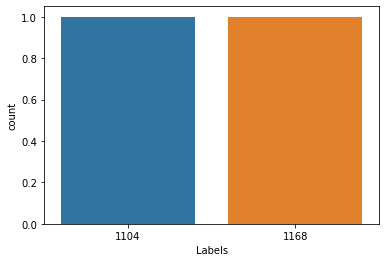

In [20]:
# Generate a count plot to visualize the count of all the labels
# In this way, we can see that the dataset is balanced between the 2 classes

print(mpl.get_backend())
mpl.use('TkAgg')
%matplotlib inline

sns.countplot(x=df_train['Labels'].value_counts());

In [21]:
# All images will be rescaled by 1./255 in order to normalize the ranges between 0 and 1
# The GAF matrices generated ar 20x20; since we have stiched 4 images - at separate time horizons - together for each completed image,
# we will mirror this setup by using 40x40 image target sizes

train_validate_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.15)  # set validation split at 15%
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_validate_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=TRAIN_PATH,
    target_size=(40, 40),
    x_col='Images',
    y_col='Labels',
    batch_size=16,
    class_mode='binary',
    subset='training')

validation_generator = train_validate_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=TRAIN_PATH,
    target_size=(40, 40),
    x_col='Images',
    y_col='Labels',
    batch_size=16,
    class_mode='binary',
    subset='validation')

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='Images',
    y_col='Labels',
    directory=TRAIN_PATH,
    target_size=(40, 40),
    class_mode='binary')

Found 1932 validated image filenames belonging to 2 classes.
Found 340 validated image filenames belonging to 2 classes.
Found 240 validated image filenames belonging to 2 classes.


In [22]:
# Show the labels for the encoded data
train_generator.class_indices

{'LONG': 0, 'SHORT': 1}

In [23]:
# We need to iterate through the generators in order to produce flattened data that can be fed into simple DNNs;
# Let's first look at the shape of the data coming from the generators
# we can see that the batch size comes first, then the shape of the image in LxW dimensions, and then the 3 color channels
next(train_generator)[0].shape

(16, 40, 40, 3)

In [24]:
# Before feeding our data into the DNN's, we need to get it into the format suitable for use; i.e. a 1D array for the inputs and a list of y-values

train_generator.reset()
X_train, y_train = next(train_generator)
for i in (range(int(len(train_generator)-1))): #1st batch is already fetched before the for loop.
    img, label = next(train_generator)
    X_train = np.append(X_train, img, axis=0 )
    y_train = np.append(y_train, label, axis=0)
print(X_train.shape, y_train.shape)

validation_generator.reset()
X_validation, y_validation = next(validation_generator)
for i in (range(int(len(validation_generator)-1))): #1st batch is already fetched before the for loop.
    img, label = next(validation_generator)
    X_validation = np.append(X_validation, img, axis=0 )
    y_validation = np.append(y_validation, label, axis=0)
print(X_validation.shape, y_validation.shape)

test_generator.reset()
X_test, y_test = next(test_generator)
for i in (range(int(len(test_generator)-1))): #1st batch is already fetched before the for loop.
    img, label = next(test_generator)
    X_test = np.append(X_test, img, axis=0 )
    y_test = np.append(y_test, label, axis=0)
print(X_test.shape, y_test.shape)

(1932, 40, 40, 3) (1932,)
(340, 40, 40, 3) (340,)
(240, 40, 40, 3) (240,)


In [25]:
# In order to flatten the data we will iterate through each instance for each datatset and use the ravel function to unfurl the color channels
# so we end up with 1D arrays of length (40x40x3) 4,800

X_train_flattened = []
X_validation_flattened = []
X_test_flattened = []

for i in range(0, len(X_train)):
            current_train = np.ravel(np.array(X_train[i], dtype="object") , order='C')
            X_train_flattened.append(current_train)
            
for i in range(0, len(X_validation)):
            current_val = np.ravel(np.array(X_validation[i], dtype="object") , order='C')
            X_validation_flattened.append(current_val)
            
for i in range(0, len(X_test)):
            current_test = np.ravel(np.array(X_test[i], dtype="object") , order='C')
            X_test_flattened.append(current_test)

In [26]:
# Look at the shape of an instance of the flattened data to ensure it has the expected dimension
X_test_flattened[0].shape

(4800,)

In [27]:
# In order to feed the data into TF.Keras model, it needs to be in an array format, as opposed to the current lists;
# Produce new arrays from the list data previously generated

X_train_flat_array = np.asarray(X_train_flattened, dtype='float32')
X_validation_flat_array = np.asarray(X_validation_flattened, dtype='float32')
X_test_flat_array = np.asarray(X_test_flattened, dtype='float32')

In [28]:
# As can be noted from the value counts (above) of 'LONG' v. 'SHORT' occurrences, the data is imbalanced;
# Let's generate a new object, 'weights' that can be fed into subsequent models to balance the calculation of 'loss', according to prevalance
# of the instances in our training data

import sklearn
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(y_train),
                                                  y_train)
print(class_weights)

# When passing class weights into a TF.Keras model, the model expects to receive a dict, so generate a dict for our new class weight data
weights = {i : class_weights[i] for i in range(2)}
print(weights)

[0.98170732 1.01898734]
{0: 0.9817073170731707, 1: 1.018987341772152}


In [29]:
# Import garbage collection and clear the backend of the TF.Keras session before beginning to build and then fit the DNN model
import gc
tf.keras.backend.clear_session()
gc.collect()

2093

In [182]:
# Let's begin our analysis by using the flattened image data to build a simple DNN as a benchmark on performance, moving forward
# In this first model, we will not apply any regularization techniques; the number of nodes will be modest at 10 in the first layer after the
# input layer and then 5 nodes in the second layer, followed by one node for the classification layer

model_DNN_1 = Sequential([
    Dense(input_shape=[4800], 
          units=10,
          kernel_initializer='he_uniform',
          activation = tf.nn.relu,),
    Dense(units=5,
          kernel_initializer='he_uniform',
          activation = tf.nn.relu),
    Dense(name = "output_layer",
          units = 1,
          activation = tf.nn.sigmoid)
])

model_DNN_1.summary()

# Now compile the model
model_DNN_1.compile(
    optimizer=tf.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'],
    )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                48010     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
output_layer (Dense)         (None, 1)                 6         
Total params: 48,071
Trainable params: 48,071
Non-trainable params: 0
_________________________________________________________________


In [183]:
history_DNN_1 = model_DNN_1.fit(X_train_flat_array,
                                y_train,
                                epochs=100,
                                batch_size=16,
                                validation_data=(X_validation_flat_array, y_validation),
                                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)],
                                class_weight=weights,
                               )

Epoch 1/100
121/121 [==============================] - 1s 3ms/step - loss: 0.6967 - accuracy: 0.4990 - val_loss: 0.6917 - val_accuracy: 0.5353
Epoch 2/100
121/121 [==============================] - 0s 2ms/step - loss: 0.6938 - accuracy: 0.5135 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 3/100
121/121 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5140 - val_loss: 0.6904 - val_accuracy: 0.5382
Epoch 4/100
121/121 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6935 - val_accuracy: 0.4588
Epoch 5/100
121/121 [==============================] - 0s 2ms/step - loss: 0.6927 - accuracy: 0.4974 - val_loss: 0.6961 - val_accuracy: 0.4559
Epoch 6/100
121/121 [==============================] - 0s 2ms/step - loss: 0.6920 - accuracy: 0.5197 - val_loss: 0.7043 - val_accuracy: 0.4500
Epoch 7/100
121/121 [==============================] - 0s 2ms/step - loss: 0.6927 - accuracy: 0.5150 - val_loss: 0.6935 - val_accuracy: 0.5265

In [184]:
# Now evaluate the model just trained
loss_DNN_1, accuracy_DNN_1 = model_DNN_1.evaluate(X_test_flat_array, y_test)
print('test set accuracy: ', accuracy_DNN_1 * 100)

8/8 [==============================] - 0s 1ms/step - loss: 0.6930 - accuracy: 0.5375
test set accuracy:  53.75000238418579


### NOTE: The distribution of "LONG" instances in the test set is 53.75%; without using any regularization, the model has fallen into the local optimum of predicting that all instances should be "LONG", it appears

In [188]:
tf.keras.backend.clear_session()

In [189]:
# Now let's build a second DNN model, using the same approach as the first, but this time adding in dropout as a regularization method

model_DNN_2 = Sequential([
    Dense(input_shape=[4800], 
          units=10,
          kernel_initializer='he_uniform',
          activation = tf.nn.relu,),
    Dropout(0.3),
    Dense(units=5,
          kernel_initializer='he_uniform',
          activation = tf.nn.relu),
    Dropout(0.3),
    Dense(name = "output_layer",
          units = 1,
          activation = tf.nn.sigmoid)
])

model_DNN_2.summary()

# Now compile the model
model_DNN_2.compile(
    optimizer=tf.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'],
    )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                48010     
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dropout_1 (Dropout)          (None, 5)                 0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 6         
Total params: 48,071
Trainable params: 48,071
Non-trainable params: 0
_________________________________________________________________


In [190]:
history_DNN_2 = model_DNN_2.fit(X_train_flat_array,
                                y_train,
                                epochs=100,
                                batch_size=16,
                                validation_data=(X_validation_flat_array, y_validation),
                                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)],
                                class_weight=weights,
                               )

Epoch 1/100
121/121 [==============================] - 1s 3ms/step - loss: 0.6945 - accuracy: 0.4933 - val_loss: 0.6932 - val_accuracy: 0.5118
Epoch 2/100
121/121 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5029
Epoch 3/100
121/121 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.5047 - val_loss: 0.6931 - val_accuracy: 0.5412
Epoch 4/100
121/121 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5093 - val_loss: 0.6931 - val_accuracy: 0.5412
Epoch 5/100
121/121 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5093 - val_loss: 0.6931 - val_accuracy: 0.5412
Epoch 6/100
121/121 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5093 - val_loss: 0.6931 - val_accuracy: 0.5412
Epoch 7/100
121/121 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5093 - val_loss: 0.6931 - val_accuracy: 0.5412

### Somewhat surprisingly, adding in dropout after the first two dense layers did not assist in the overfitting. I will now try to pair the dropout with a reduced learning rate to see if this makes an impact.

In [195]:
tf.keras.backend.clear_session()

In [196]:
# Now let's build a second DNN model, using the same approach as the first, but this time adding in dropout as a regularization method

model_DNN_3 = Sequential([
    Dense(input_shape=[4800], 
          units=10,
          kernel_initializer='he_uniform',
          activation = tf.nn.relu,),
    Dropout(0.3),
    Dense(units=5,
          kernel_initializer='he_uniform',
          activation = tf.nn.relu),
    Dropout(0.3),
    Dense(name = "output_layer",
          units = 1,
          activation = tf.nn.sigmoid)
])

model_DNN_3.summary()

# Now compile the model
model_DNN_3.compile(
    optimizer=tf.optimizers.Adam(learning_rate=1e-6),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'],
    )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                48010     
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dropout_1 (Dropout)          (None, 5)                 0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 6         
Total params: 48,071
Trainable params: 48,071
Non-trainable params: 0
_________________________________________________________________


In [197]:
history_DNN_3 = model_DNN_3.fit(X_train_flat_array,
                                y_train,
                                epochs=100,
                                batch_size=16,
                                validation_data=(X_validation_flat_array, y_validation),
                                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)],
                                class_weight=weights,
                               )

Epoch 1/100
121/121 [==============================] - 1s 3ms/step - loss: 0.9550 - accuracy: 0.5036 - val_loss: 0.7195 - val_accuracy: 0.4824
Epoch 2/100
121/121 [==============================] - 0s 2ms/step - loss: 0.8355 - accuracy: 0.4974 - val_loss: 0.7001 - val_accuracy: 0.5206
Epoch 3/100
121/121 [==============================] - 0s 2ms/step - loss: 0.7990 - accuracy: 0.5098 - val_loss: 0.6945 - val_accuracy: 0.5088
Epoch 4/100
121/121 [==============================] - 0s 2ms/step - loss: 0.7764 - accuracy: 0.4953 - val_loss: 0.6926 - val_accuracy: 0.5029
Epoch 5/100
121/121 [==============================] - 0s 2ms/step - loss: 0.7719 - accuracy: 0.4881 - val_loss: 0.6919 - val_accuracy: 0.5265
Epoch 6/100
121/121 [==============================] - 0s 2ms/step - loss: 0.7570 - accuracy: 0.4948 - val_loss: 0.6918 - val_accuracy: 0.5353
Epoch 7/100
121/121 [==============================] - 0s 2ms/step - loss: 0.7547 - accuracy: 0.4891 - val_loss: 0.6924 - val_accuracy: 0.5324

In [198]:
# Now evaluate the model just trained
loss_DNN_3, accuracy_DNN_3 = model_DNN_3.evaluate(X_test_flat_array, y_test)
print('test set accuracy: ', accuracy_DNN_3 * 100)

8/8 [==============================] - 0s 1ms/step - loss: 0.6932 - accuracy: 0.5375
test set accuracy:  53.75000238418579


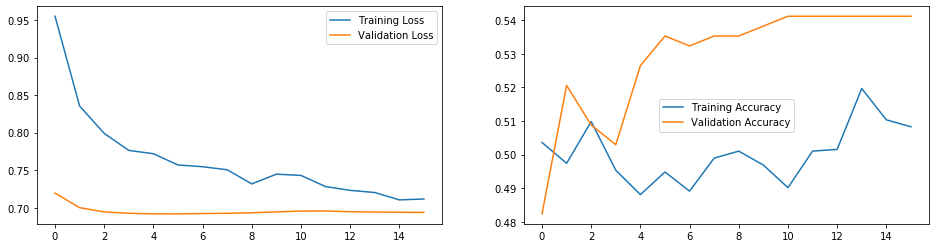

In [199]:
# Generate a plot of the training and validation losses and accuracies for the current model

plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([history_DNN_3.history['loss'], history_DNN_3.history['accuracy']], 
                                [history_DNN_3.history['val_loss'], history_DNN_3.history['val_accuracy']], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(len(history_DNN_3.history['loss'])), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(len(history_DNN_3.history['loss'])), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

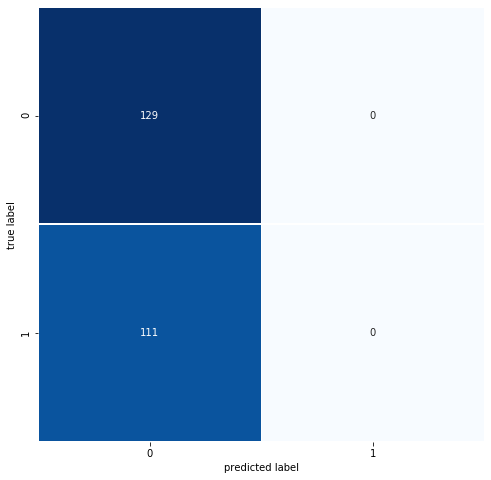

In [203]:
# Produce a confusion matrix displaying the results of predicted and true classes

plot_confusion_matrix(y_test, np.argmax(model_DNN_3.predict(np.array(X_test_flat_array)), axis=-1))

In [290]:
model_DNN_3.predict(np.array(X_test_flat_array))[0:10]

array([[0.4999957 ],
       [0.4999957 ],
       [0.4999957 ],
       [0.4298066 ],
       [0.4999957 ],
       [0.4999957 ],
       [0.4999957 ],
       [0.4999957 ],
       [0.4999957 ],
       [0.45493376]], dtype=float32)

In [260]:
np.argmax(model_DNN_3.predict(np.array(X_test_flat_array)), axis=-1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Reducing the learning rate to 1e-6 from 1e-4 does appear to have helped, but after about 10 epochs the model settled back into the local optima that is not useful in make predictions; I will run a series of DNN's testing higher levels of regularization and a range of learning rates along with a range of kernel initializers in order to see what impact this has. I will also decrease 'patience' to 3 in order to attempt to end the fitting process before the local optima is reached

In [ ]:
# Let's produce a function that can be used to tune hyperparameters on the DNN model

In [209]:
tf.keras.backend.clear_session()

In [210]:
# Create objects for the hyperparameters that will be tuned

HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([10, 16, 32, 64]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.4, 0.5))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['sgd', 'adam']))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([0.0001, 0.00001, 0.000001, 0.0000001]))
HP_KERNEL_INITIALIZER = hp.HParam('initializer', hp.Discrete(['he_normal', 'he_uniform']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning_DNN_1').as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER, HP_LEARNING_RATE, HP_KERNEL_INITIALIZER],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )

In [215]:
def train_val_test_model(hparams):
    
    # Set the initializer
    initializer = hparams[HP_KERNEL_INITIALIZER]
    if initializer =="he_uniform":
        initializer = tf.keras.initializers.HeUniform(seed=None)
    elif initializer=="he_normal":
        initializer = tf.keras.initializers.HeNormal(seed=None)
    elif initializer=="glorot_uniform":
        initializer = tf.keras.initializers.GlorotUniform(seed=None)
    elif initializer=="glorot_normal":
        initializer = tf.keras.initializers.GlorotNormal(seed=None)
    elif initializer=="lecun_uniform":
        initializer = tf.keras.initializers.LecunUniform(seed=None)
    elif initializer=="lecun_normal":
        initializer = tf.keras.initializers.LecunNormal(seed=None)
    else:
        raise ValueError("unexpected initializer name: %r" % (initializer_name,))
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(input_shape=[4800], 
                              units=hparams[HP_NUM_UNITS],
                              activation=tf.nn.relu,
                              kernel_initializer=hparams[HP_KERNEL_INITIALIZER]),
        tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
        # Divide the number of dense units in this layer by 2 to make it half the number of the first layer
        tf.keras.layers.Dense(units=(hparams[HP_NUM_UNITS]/2),
                              activation=tf.nn.relu,
                              kernel_initializer=hparams[HP_KERNEL_INITIALIZER]),
        tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
        tf.keras.layers.Dense(1, activation=tf.nn.sigmoid),
    ])
    
    # Setting the optimizer and learning rate
    optimizer = hparams[HP_OPTIMIZER]
    learning_rate = hparams[HP_LEARNING_RATE]
    if optimizer == "adam":
        optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == "sgd":
        optimizer = tf.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer=='rmsprop':
        optimizer = tf.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("unexpected optimizer name: %r" % (optimizer_name,))
    
    # Compiling the model
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=['accuracy'],
    )

    model.fit(X_train_flat_array, 
              y_train, 
              epochs=20,
              validation_data=(X_validation_flat_array, y_validation),
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])
    _, accuracy = model.evaluate(X_test_flat_array, y_test)
    return accuracy

In [216]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_val_test_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [217]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        for optimizer in HP_OPTIMIZER.domain.values:
            for learning_rate in HP_LEARNING_RATE.domain.values:
                for initializer in HP_KERNEL_INITIALIZER.domain.values:
                    hparams = {
                    HP_NUM_UNITS: num_units,
                    HP_DROPOUT: dropout_rate,
                    HP_OPTIMIZER: optimizer,
                    HP_LEARNING_RATE: learning_rate,
                    HP_KERNEL_INITIALIZER: initializer,
                    }
                    run_name = "run-%d" % session_num
                    print('--- Starting trial: %s' % run_name)
                    print({h.name: hparams[h] for h in hparams})
                    run('logs/hparam_tuning_DNN_1/' + run_name, hparams)
                    session_num += 1

--- Starting trial: run-0
{'num_units': 10, 'dropout': 0.4, 'optimizer': 'adam', 'learning_rate': 1e-07, 'initializer': 'he_normal'}
Epoch 1/20
61/61 [==============================] - 0s 3ms/step - loss: 0.7465 - accuracy: 0.5176 - val_loss: 0.6979 - val_accuracy: 0.4941
Epoch 2/20
61/61 [==============================] - 0s 2ms/step - loss: 0.7466 - accuracy: 0.5129 - val_loss: 0.6977 - val_accuracy: 0.4971
Epoch 3/20
61/61 [==============================] - 0s 2ms/step - loss: 0.7466 - accuracy: 0.4948 - val_loss: 0.6976 - val_accuracy: 0.5000
Epoch 4/20
61/61 [==============================] - 0s 2ms/step - loss: 0.7395 - accuracy: 0.5155 - val_loss: 0.6975 - val_accuracy: 0.5000
Epoch 5/20
61/61 [==============================] - 0s 2ms/step - loss: 0.7409 - accuracy: 0.5021 - val_loss: 0.6974 - val_accuracy: 0.5059
Epoch 6/20
61/61 [==============================] - 0s 2ms/step - loss: 0.7305 - accuracy: 0.4979 - val_loss: 0.6973 - val_accuracy: 0.5088
Epoch 7/20
61/61 [=========

In [30]:
# Load Tensorboard
%tensorboard --logdir logs/hparam_tuning_DNN_1/
#!kill 625273

In [ ]:
# Now let's switch gears and begin looking at the CNN models and how they perform on the 40x40x3 image data

In [411]:
tf.keras.backend.clear_session()

In [412]:
# Begin with an unregularized 2 layer CNN to see how it performs

# First CNN Model test; with limited regularization

model_CNN_base = tf.keras.models.Sequential()
model_CNN_base.add(layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(40, 40, 3), 
                              kernel_initializer='he_uniform'))
model_CNN_base.add(layers.MaxPool2D((2, 2),strides=2))
model_CNN_base.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, 
                              kernel_initializer='he_uniform'))
model_CNN_base.add(layers.MaxPool2D((2, 2),strides=2))
model_CNN_base.add(layers.Flatten())
model_CNN_base.add(layers.Dense(units=1, activation=tf.nn.sigmoid))   

# Compiling the model
model_CNN_base.compile(
    optimizer=tf.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'],
    )

In [413]:
history_base = model_CNN_base.fit(train_generator,
                            epochs=20,
                            batch_size=16,
                            validation_data=validation_generator,
                            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)],
                            class_weight=weights,
                           )

Epoch 1/20
121/121 [==============================] - 9s 70ms/step - loss: 0.7209 - accuracy: 0.5072 - val_loss: 0.6883 - val_accuracy: 0.5324
Epoch 2/20
121/121 [==============================] - 8s 70ms/step - loss: 0.6992 - accuracy: 0.5316 - val_loss: 0.7073 - val_accuracy: 0.5294
Epoch 3/20
121/121 [==============================] - 8s 69ms/step - loss: 0.6946 - accuracy: 0.5357 - val_loss: 0.6905 - val_accuracy: 0.5294


In [414]:
# Now evaluate the model just trained
loss_CNN_base, accuracy_CNN_base = model_CNN_base.evaluate(X_test, y_test)
print('test set accuracy: ', accuracy_CNN_base * 100)

8/8 [==============================] - 0s 2ms/step - loss: 0.6829 - accuracy: 0.5625
test set accuracy:  56.25


In [219]:
tf.keras.backend.clear_session()

In [220]:
# First CNN Model test; with limited regularization

model_CNN_1 = tf.keras.models.Sequential()
model_CNN_1.add(layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(40, 40, 3), 
                              kernel_initializer='he_uniform'))
model_CNN_1.add(layers.MaxPool2D((2, 2),strides=2))
model_CNN_1.add(layers.Dropout(0.4))
model_CNN_1.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, 
                              kernel_initializer='he_uniform'))
model_CNN_1.add(layers.MaxPool2D((2, 2),strides=2))
model_CNN_1.add(layers.Dropout(0.4))
model_CNN_1.add(layers.Flatten())
model_CNN_1.add(layers.Dense(units=1, activation=tf.nn.sigmoid))   

# Compiling the model
model_CNN_1.compile(
    optimizer=tf.optimizers.Adam(learning_rate=1e-6),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'],
    )

In [221]:
history_1 = model_CNN_1.fit(train_generator,
                            epochs=20,
                            batch_size=16,
                            validation_data=validation_generator,
                            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)],
                            class_weight=weights,
                           )

Epoch 1/20
121/121 [==============================] - 9s 71ms/step - loss: 1.3367 - accuracy: 0.4860 - val_loss: 0.7081 - val_accuracy: 0.5324
Epoch 2/20
121/121 [==============================] - 8s 69ms/step - loss: 1.1902 - accuracy: 0.5021 - val_loss: 0.7040 - val_accuracy: 0.5147
Epoch 3/20
121/121 [==============================] - 8s 70ms/step - loss: 1.1340 - accuracy: 0.5078 - val_loss: 0.7102 - val_accuracy: 0.5029


In [309]:
# Now evaluate the model just trained
loss_CNN_1, accuracy_CNN_1 = model_CNN_1.evaluate(X_test, y_test)
print('test set accuracy: ', accuracy_CNN_1 * 100)

8/8 [==============================] - 0s 2ms/step - loss: 0.6788 - accuracy: 0.5875
test set accuracy:  58.74999761581421


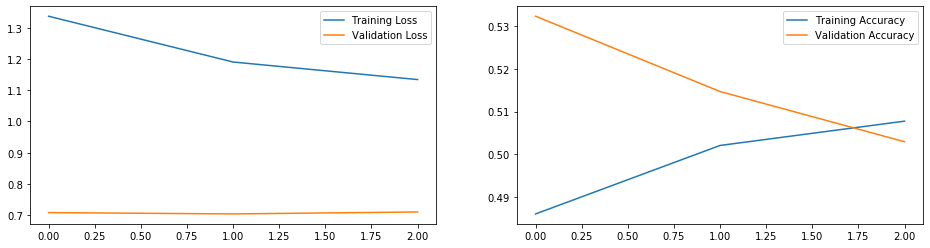

In [223]:
# Generate a plot of the training and validation losses and accuracies for the current model

plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([history_1.history['loss'], history_1.history['accuracy']], 
                                [history_1.history['val_loss'], history_1.history['val_accuracy']], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(len(history_1.history['loss'])), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(len(history_1.history['loss'])), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [310]:
CNN_1_test_predict = np.asarray((model_CNN_1.predict(X_test)), dtype='float32')

In [313]:
predict_list = []
for i in range(0, len(CNN_1_test_predict)):
    if (CNN_1_test_predict[i] >=0.50) == True:
        current_predict = 1
        predict_list.append(current_predict)
    else:
        current_predict = 0
        predict_list.append(current_predict)

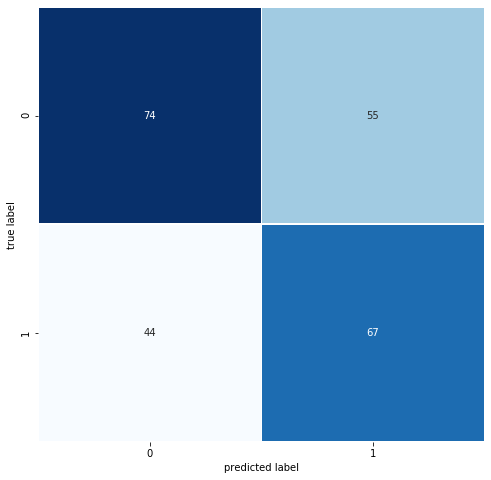

In [316]:
# Produce a confusion matrix displaying the results of predicted and true classes

plot_confusion_matrix(y_test, np.array(predict_list))

In [317]:
CNN_1_predicts = model_CNN_1.predict(test_generator)
print(CNN_1_predicts.min())
print(CNN_1_predicts.max())

0.32474494
0.6872891


### Based on the results of this first CNN model, it appears that predictive accuracy above the level expected by random selection is possible using shallow CNN models that include regularization and early stopping to avoid overfitting, which occurs quite quickly

In [318]:
# Now I will test out a similar model, but this time with batch normalization included as a regularization technique

In [319]:
# Clear backend and collect garbage before fitting new model
tf.keras.backend.clear_session()

In [320]:
model_CNN_2 = tf.keras.models.Sequential()
model_CNN_2.add(layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(40, 40, 3), 
                              kernel_initializer='he_uniform'))
model_CNN_2.add(layers.MaxPool2D((2, 2),strides=2))
model_CNN_2.add(layers.BatchNormalization())
model_CNN_2.add(layers.Dropout(0.4))
model_CNN_2.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, 
                              kernel_initializer='he_uniform'))
model_CNN_2.add(layers.MaxPool2D((2, 2),strides=2))
model_CNN_2.add(layers.BatchNormalization())
model_CNN_2.add(layers.Dropout(0.4))
model_CNN_2.add(layers.Flatten())
model_CNN_2.add(layers.Dense(units=1, activation=tf.nn.sigmoid))   

# Compiling the model
model_CNN_2.compile(
    optimizer=tf.optimizers.Adam(learning_rate=1e-6),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'],
    )

In [321]:
history_2 = model_CNN_2.fit(train_generator,
                            epochs=20,
                            batch_size=16,
                            validation_data=validation_generator,
                            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)],
                            class_weight=weights
                           )

Epoch 1/20
121/121 [==============================] - 9s 71ms/step - loss: 0.9859 - accuracy: 0.5026 - val_loss: 0.7362 - val_accuracy: 0.4853
Epoch 2/20
121/121 [==============================] - 9s 71ms/step - loss: 0.9934 - accuracy: 0.5155 - val_loss: 0.7609 - val_accuracy: 0.4765
Epoch 3/20
121/121 [==============================] - 8s 70ms/step - loss: 0.9689 - accuracy: 0.4938 - val_loss: 0.7620 - val_accuracy: 0.4853


In [322]:
# Now evaluate the model just trained
loss_CNN_2, accuracy_CNN_2 = model_CNN_2.evaluate(X_test, y_test)
print('test set accuracy: ', accuracy_CNN_2 * 100)

8/8 [==============================] - 0s 1ms/step - loss: 0.7553 - accuracy: 0.5167
test set accuracy:  51.66666507720947


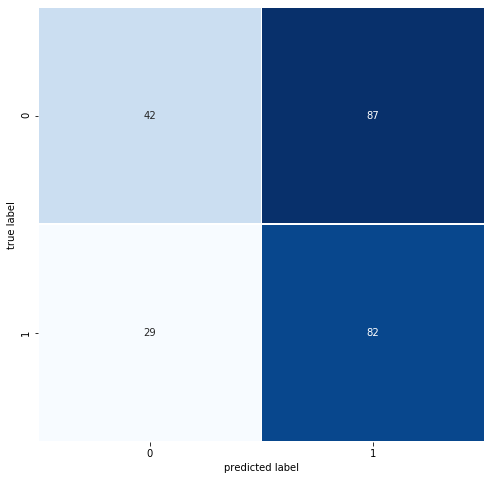

In [323]:
CNN_2_test_predict = np.asarray((model_CNN_2.predict(X_test)), dtype='float32')

predict_list = []
for i in range(0, len(CNN_2_test_predict)):
    if (CNN_2_test_predict[i] >=0.50) == True:
        current_predict = 1
        predict_list.append(current_predict)
    else:
        current_predict = 0
        predict_list.append(current_predict)
        
# Produce a confusion matrix displaying the results of predicted and true classes
plot_confusion_matrix(y_test, np.array(predict_list))

### Interestingly, this model predicts the occurrence of '1' or 'SHORT' more often than '0' or 'LONG', this may indicate that ensembling models (as the last model predicts more 0's than 1's) could be a fruitful exercise; also, using the batch normalization does appear to have slowed overfitting in this specific trial. I will now try to build the same model, but will a higher 'patience' than 2 and see how that works. I will also include a 'reduce_learningrate' callback in order to see if that helps overfitting as well.

In [324]:
# Clear backend and collect garbage before fitting new model
tf.keras.backend.clear_session()

In [368]:
# Let's try a new call-back to reduce learning rate on a plateau and add it to this next model iteration
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor = 0.1, 
                                                 patience = 1)

In [415]:
model_CNN_3 = tf.keras.models.Sequential()
model_CNN_3.add(layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(40, 40, 3), 
                              kernel_initializer='he_uniform'))
model_CNN_3.add(layers.MaxPool2D((2, 2),strides=2))
model_CNN_3.add(layers.BatchNormalization())
model_CNN_3.add(layers.Dropout(0.4))
model_CNN_3.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, 
                              kernel_initializer='he_uniform'))
model_CNN_3.add(layers.MaxPool2D((2, 2),strides=2))
model_CNN_3.add(layers.BatchNormalization())
model_CNN_3.add(layers.Dropout(0.4))
model_CNN_3.add(layers.Flatten())
model_CNN_3.add(layers.Dense(units=1, activation=tf.nn.sigmoid))   

# Compiling the model
model_CNN_3.compile(
    optimizer=tf.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'],
    )

In [416]:
history_3 = model_CNN_3.fit(train_generator,
                            epochs=20,
                            batch_size=16,
                            validation_data=validation_generator,
                            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
                                      reduce_lr],
                            class_weight=weights
                           )

Epoch 1/20
121/121 [==============================] - 9s 71ms/step - loss: 0.9789 - accuracy: 0.4943 - val_loss: 0.7034 - val_accuracy: 0.4941
Epoch 2/20
121/121 [==============================] - 8s 70ms/step - loss: 0.9183 - accuracy: 0.5114 - val_loss: 0.7311 - val_accuracy: 0.5382
Epoch 3/20
121/121 [==============================] - 9s 71ms/step - loss: 0.9153 - accuracy: 0.5124 - val_loss: 0.7471 - val_accuracy: 0.5412
Epoch 4/20
121/121 [==============================] - 8s 70ms/step - loss: 0.9129 - accuracy: 0.5088 - val_loss: 0.7505 - val_accuracy: 0.5294
Epoch 5/20
121/121 [==============================] - 8s 69ms/step - loss: 0.8743 - accuracy: 0.5497 - val_loss: 0.7518 - val_accuracy: 0.5235
Epoch 6/20
121/121 [==============================] - 8s 70ms/step - loss: 0.8999 - accuracy: 0.5057 - val_loss: 0.7519 - val_accuracy: 0.5235
Epoch 7/20
121/121 [==============================] - 8s 70ms/step - loss: 0.8968 - accuracy: 0.5160 - val_loss: 0.7518 - val_accuracy: 0.5324

In [417]:
# Now evaluate the model just trained
loss_CNN_3, accuracy_CNN_3 = model_CNN_3.evaluate(X_test, y_test)
print('test set accuracy: ', accuracy_CNN_3 * 100)

8/8 [==============================] - 0s 2ms/step - loss: 0.7255 - accuracy: 0.5167
test set accuracy:  51.66666507720947


<ipython-input-418-ad21dd2146bc>:10: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


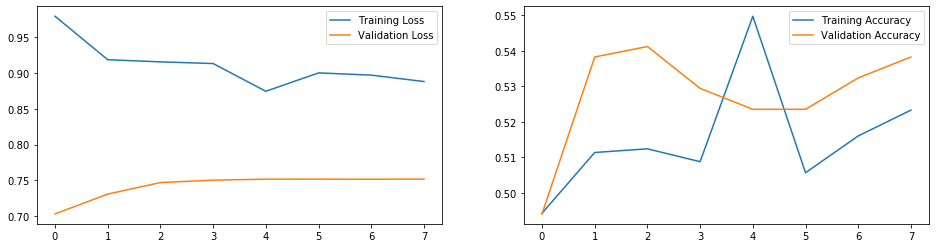

In [418]:
# Generate a plot of the training and validation losses and accuracies for the current model

plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([history_3.history['loss'], history_3.history['accuracy']], 
                                [history_3.history['val_loss'], history_3.history['val_accuracy']], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(len(history_3.history['loss'])), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(len(history_3.history['loss'])), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

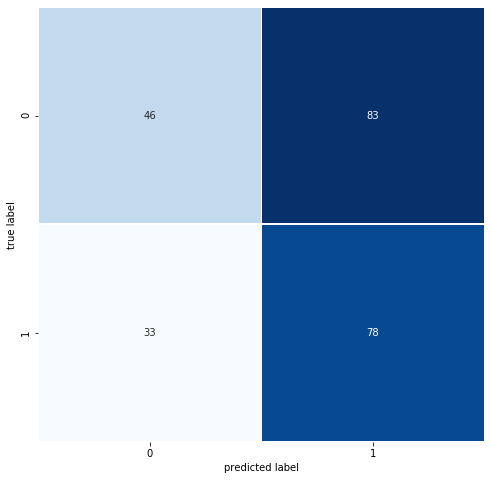

In [419]:
CNN_3_test_predict = np.asarray((model_CNN_3.predict(X_test)), dtype='float32')

predict_list = []
for i in range(0, len(CNN_3_test_predict)):
    if (CNN_3_test_predict[i] >=0.50) == True:
        current_predict = 1
        predict_list.append(current_predict)
    else:
        current_predict = 0
        predict_list.append(current_predict)
        
# Produce a confusion matrix displaying the results of predicted and true classes
plot_confusion_matrix(y_test, np.array(predict_list))

### Even when using extremely similar model architectures, model accuracy on the test set can vary dramatically. It appears that the random kernel initializers may play a significant role in the end model efficacy; it may be a good idea to test a number of initializers

In [ ]:
# Before engaging in hyperparameter tuning with the shallower CNN architecture, let's attempt to use a stacked CNN architecture to
# see if this can produce better results on our dataset

In [425]:
# Clear backend and collect garbage before fitting new model
tf.keras.backend.clear_session()

In [427]:
# Let's now used stacked convolutional layers, with dropout and batch normalization for reuglarization

model_CNN_4 = Sequential()
model_CNN_4.add(Conv2D(input_shape=(40,40,3),filters=64,kernel_size=(3,3),padding="same", activation="relu", kernel_initializer='he_uniform'))
model_CNN_4.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu", kernel_initializer='he_uniform'))
model_CNN_4.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model_CNN_4.add(layers.BatchNormalization())
model_CNN_4.add(layers.Dropout(0.4))

model_CNN_4.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer='he_uniform'))
model_CNN_4.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer='he_uniform'))
model_CNN_4.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model_CNN_4.add(layers.BatchNormalization())
model_CNN_4.add(layers.Dropout(0.4))

model_CNN_4.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer='he_uniform'))
model_CNN_4.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer='he_uniform'))
model_CNN_4.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer='he_uniform'))
model_CNN_4.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model_CNN_4.add(layers.BatchNormalization())
model_CNN_4.add(layers.Dropout(0.4))

# Now flatten the output and add Dense layers for classification
model_CNN_4.add(Flatten())
model_CNN_4.add(Dense(units=1024,activation="relu", kernel_initializer='he_uniform'))
model_CNN_4.add(layers.Dropout(0.4))
model_CNN_4.add(layers.BatchNormalization())
model_CNN_4.add(Dense(units=256,activation="relu", kernel_initializer='he_uniform'))
model_CNN_4.add(Dense(units=1, activation="sigmoid"))

model_CNN_4.summary()

# Compiling the model
model_CNN_4.compile(
    optimizer=tf.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'],
    )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 40, 40, 64)        1792      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 40, 40, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 20, 20, 64)        256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 20, 20, 128)      

In [428]:
history_4 = model_CNN_4.fit(train_generator,
                            epochs=20,
                            batch_size=16,
                            validation_data=validation_generator,
                            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4),
                                      reduce_lr],
                            class_weight=weights
                           )

Epoch 1/20
121/121 [==============================] - 9s 72ms/step - loss: 0.8340 - accuracy: 0.5119 - val_loss: 0.7173 - val_accuracy: 0.5000
Epoch 2/20
121/121 [==============================] - 9s 71ms/step - loss: 0.8008 - accuracy: 0.5176 - val_loss: 0.7203 - val_accuracy: 0.5000
Epoch 3/20
121/121 [==============================] - 9s 71ms/step - loss: 0.7808 - accuracy: 0.5145 - val_loss: 0.7462 - val_accuracy: 0.4853
Epoch 4/20
121/121 [==============================] - 8s 70ms/step - loss: 0.7977 - accuracy: 0.5057 - val_loss: 0.7498 - val_accuracy: 0.4853
Epoch 5/20
121/121 [==============================] - 9s 70ms/step - loss: 0.7721 - accuracy: 0.5057 - val_loss: 0.7525 - val_accuracy: 0.4853


In [429]:
# Now evaluate the model just trained
loss_CNN_4, accuracy_CNN_4 = model_CNN_4.evaluate(X_test, y_test)
print('test set accuracy: ', accuracy_CNN_4 * 100)

8/8 [==============================] - 0s 3ms/step - loss: 0.6989 - accuracy: 0.5208
test set accuracy:  52.08333134651184


<ipython-input-430-45ac82afd11c>:10: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


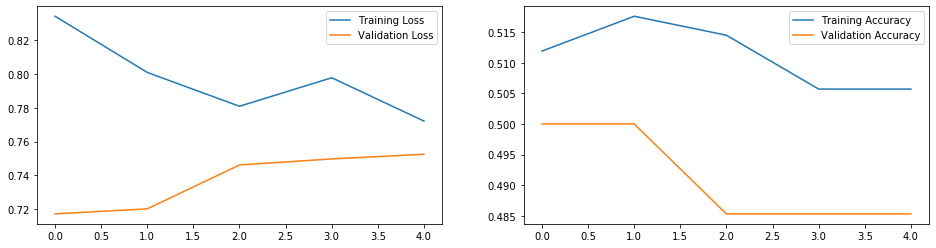

In [430]:
# Generate a plot of the training and validation losses and accuracies for the current model

plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([history_4.history['loss'], history_4.history['accuracy']], 
                                [history_4.history['val_loss'], history_4.history['val_accuracy']], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(len(history_4.history['loss'])), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(len(history_4.history['loss'])), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

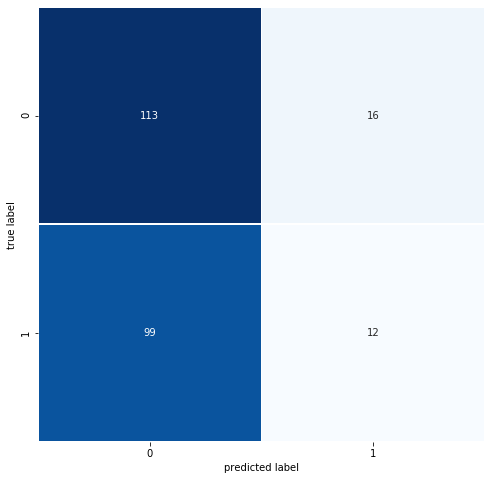

In [431]:
CNN_4_test_predict = np.asarray((model_CNN_4.predict(X_test)), dtype='float32')

predict_list = []
for i in range(0, len(CNN_4_test_predict)):
    if (CNN_4_test_predict[i] >=0.50) == True:
        current_predict = 1
        predict_list.append(current_predict)
    else:
        current_predict = 0
        predict_list.append(current_predict)
        
# Produce a confusion matrix displaying the results of predicted and true classes
plot_confusion_matrix(y_test, np.array(predict_list))

<ipython-input-432-c4babc7a00a8>:9: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


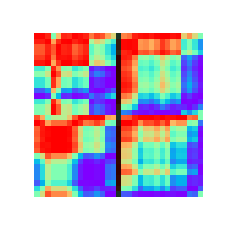

In [432]:
# Generate an image tensor from which to visualize the feature maps extracted by the model

img = X_test[random.randint(0,240)]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [433]:
# Extracts the outputs of the layers in the CNN model:
layer_outputs_CNN_4 = [layer.output for layer in model_CNN_4.layers[:]]

# Creates a model that will return these outputs, given the model input:
activation_model_CNN_4 = models.Model(inputs=model_CNN_4.input, outputs=layer_outputs_CNN_4)

In [434]:
# Check to see the length of the activation_model object
activations = activation_model_CNN_4.predict(img_tensor)
len(activations)

22

In [435]:
layer_names = []
for layer in model_CNN_4.layers:
    layer_names.append(layer.name)

<ipython-input-436-abf6314f18b4>:28: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()
<ipython-input-436-abf6314f18b4>:28: RuntimeWarning: divide by zero encountered in true_divide
  channel_image /= channel_image.std()
<ipython-input-436-abf6314f18b4>:43: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show();


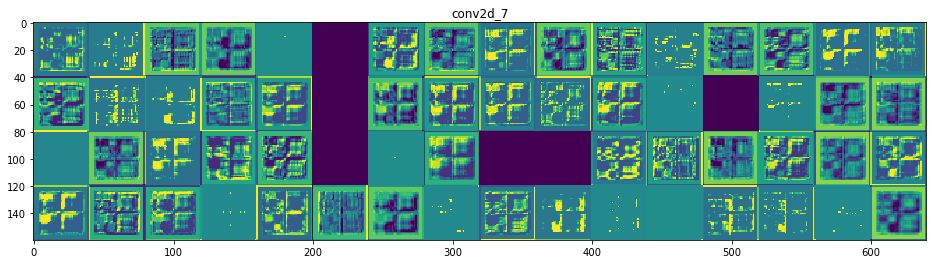

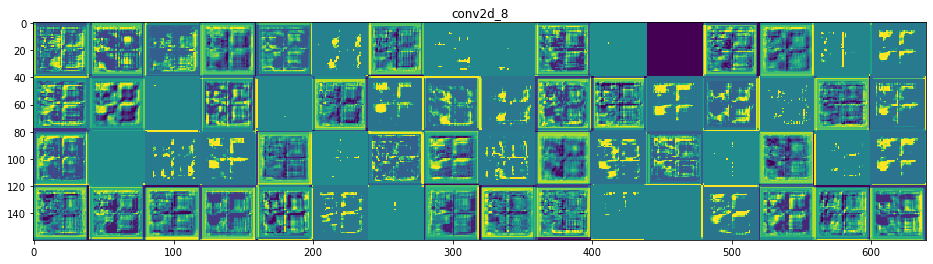

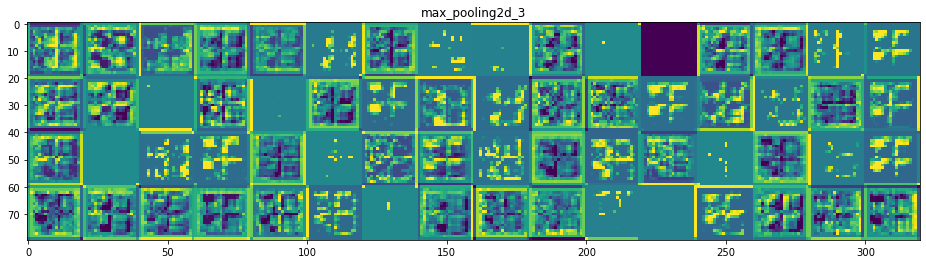

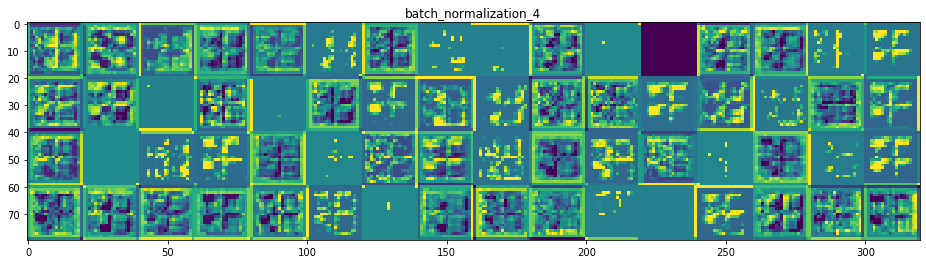

In [436]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model_CNN_4.layers[:4]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();

In [449]:
# Create a new object containing the test categories
def create_test_cats(y_test):
    test_categories = []
    for y in y_test:
        if y == 0.:
            test_categories.append('LONG')
        else:
            test_categories.append('SHORT')
    np.array(test_categories)
    return test_categories

test_categories = create_test_cats(y_test)

In [452]:
test_categories = {'LONG':0, 'SHORT':1}

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 240 samples in 0.000s...
[t-SNE] Computed neighbors for 240 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 240 / 240
[t-SNE] Mean sigma: 1.977745
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.039589
[t-SNE] KL divergence after 300 iterations: 0.944720


<ipython-input-453-7fee79e508d7>:28: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


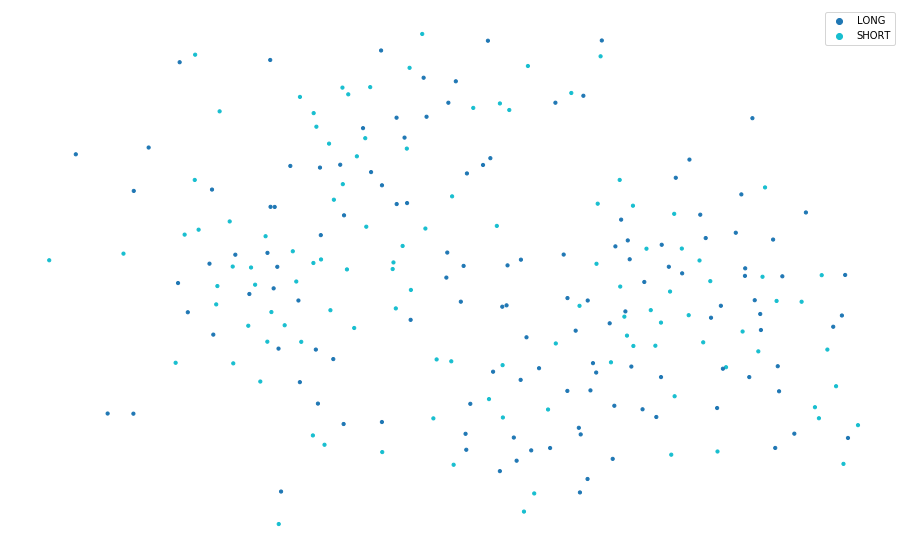

In [453]:
from sklearn.manifold import TSNE

# First, extract the outputs of all layers of the model:
layer_outputs_CNN_4 = [layer.output for layer in model_CNN_4.layers]
    
# Now, create a model that will return these outputs from the layers, given the model input:
activation_model_CNN_4 = tf.keras.models.Model(inputs=model_CNN_4.input, outputs=layer_outputs_CNN_4)

# Next, get the activation values for the last dense layer of the GRU model
activations_CNN_4 = activation_model_CNN_4.predict(X_test)
dense_layer_activations_CNN_4 = activations_CNN_4[-2]
output_layer_activations_CNN_4 = activations_CNN_4[-1]
    
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_layer_activations_CNN_4)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())
    
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=y_test, 
                        s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=test_categories)

plt.axis("off")
plt.show()

In [ ]:
# Let's work on hyperparameter tuning for the basic CNN architecture

In [157]:
# Create objects for the hyperparameters that will be tuned in the CNN models

HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([256, 512]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.3, 0.4))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
HP_KERNEL_INITIALIZER = hp.HParam('initializer', hp.Discrete(['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal', 'lecun_uniform',
                                                             'lecun_normal']))
HP_FILTER_NUM = hp.HParam('filters', hp.Discrete([16, 32, 64]))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([0.01, 0.001, 0.0001]))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning_CNN_1').as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER, HP_KERNEL_INITIALIZER, HP_FILTER_NUM, HP_LEARNING_RATE],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )

In [158]:
# This time, generate a CNN model building function that can use a new input, "num_layers" that will dictate how many convolutional layers
# will be used in the model (between 1 and 4)

def train_val_test_CNN(hparams, num_layers):
    # Set the initializer
    initializer = hparams[HP_KERNEL_INITIALIZER]
    if initializer =="he_uniform":
        initializer = tf.keras.initializers.HeUniform(seed=None)
    elif initializer=="he_normal":
        initializer = tf.keras.initializers.HeNormal(seed=None)
    elif initializer=="glorot_uniform":
        initializer = tf.keras.initializers.GlorotUniform(seed=None)
    elif initializer=="glorot_normal":
        initializer = tf.keras.initializers.GlorotNormal(seed=None)
    elif initializer=="lecun_uniform":
        initializer = tf.keras.initializers.LecunUniform(seed=None)
    elif initializer=="lecun_normal":
        initializer = tf.keras.initializers.LecunNormal(seed=None)
    else:
        raise ValueError("unexpected initializer name: %r" % (initializer_name,))

    model = tf.keras.models.Sequential()
    model.add(layers.Conv2D(filters=hparams[HP_FILTER_NUM], kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(40, 40, 3), 
                            kernel_initializer=hparams[HP_KERNEL_INITIALIZER]))
    model.add(layers.MaxPool2D((2, 2),strides=2))
    model.add(layers.Dropout(hparams[HP_DROPOUT]))
        
    # If the number of layers is set to two, execute this section of code
    if num_layers == 2:
        model.add(layers.Conv2D(filters=(hparams[HP_FILTER_NUM]*2), kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, 
                                kernel_initializer=hparams[HP_KERNEL_INITIALIZER]))
        model.add(layers.MaxPool2D((2, 2),strides=2))
        model.add(layers.Dropout(hparams[HP_DROPOUT]))
        
    # If the number of layers is set to three, execute this section of code
    elif num_layers == 3:
        model.add(layers.Conv2D(filters=(hparams[HP_FILTER_NUM]*2), kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, 
                                kernel_initializer=hparams[HP_KERNEL_INITIALIZER]))
        model.add(layers.MaxPool2D((2, 2),strides=2))
        model.add(layers.Dropout(hparams[HP_DROPOUT]))
        
        model.add(layers.Conv2D(filters=(hparams[HP_FILTER_NUM]*4), kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, 
                                kernel_initializer=hparams[HP_KERNEL_INITIALIZER]))
        model.add(layers.MaxPool2D((2, 2),strides=2))
        model.add(layers.Dropout(hparams[HP_DROPOUT]))
        
    # If the number of layers is set to four, execute this section of code
    elif num_layers == 4:
        model.add(layers.Conv2D(filters=(hparams[FHP_ILTER_NUM]*2), kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, 
                                kernel_initializer=hparams[HP_KERNEL_INITIALIZER]))
        model.add(layers.MaxPool2D((2, 2),strides=2))
        model.add(layers.Dropout(hparams[HP_DROPOUT]))
        
        model.add(layers.Conv2D(filters=(hparams[HP_FILTER_NUM]*4), kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, 
                                kernel_initializer=hparams[HP_KERNEL_INITIALIZER]))
        model.add(layers.MaxPool2D((2, 2),strides=2))
        model.add(layers.Dropout(hparams[HP_DROPOUT]))
            
        model.add(layers.Conv2D(filters=(hparams[HP_FILTER_NUM]*8), kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, 
                                kernel_initializer=hparams[HP_KERNEL_INITIALIZER]))
        model.add(layers.MaxPool2D((2, 2),strides=2))
        model.add(layers.Dropout(hparams[HP_DROPOUT]))
        
    else:
        raise ValueError("Must choose 2 to 4 layers: %r" % (num_layers,))

    model.add(layers.Flatten())    
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(units=hparams[HP_NUM_UNITS], activation=tf.nn.relu))
    model.add(layers.Dense(units=1, activation=tf.nn.sigmoid))   

    
    
    # Setting the initializer, optimizer and learning rate
    optimizer = hparams[HP_OPTIMIZER]
    learning_rate = hparams[HP_LEARNING_RATE]
    if optimizer == "adam":
        optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer=='rmsprop':
        optimizer = tf.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer=='sgd':
        optimizer = tf.optimizers.SGD(learning_rate=learning_rate)
    else:
        raise ValueError("unexpected optimizer name: %r" % (optimizer_name,))
    

    # Compiling the model
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=['accuracy'],
    )

    model.fit(train_generator, 
              epochs=20,
              validation_data=validation_generator,
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)],
              class_weight=weights)
    _, accuracy = model.evaluate(test_generator)
    return accuracy

In [159]:
def run_CNN(run_dir, hparams, num_layers):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_val_test_CNN(hparams, num_layers)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [160]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        for optimizer in HP_OPTIMIZER.domain.values:
            for initializer in HP_KERNEL_INITIALIZER.domain.values:
                for learning_rate in HP_LEARNING_RATE.domain.values:
                    for filters in HP_FILTER_NUM.domain.values:
                        hparams = {
                        HP_NUM_UNITS: num_units,
                        HP_DROPOUT: dropout_rate,
                        HP_OPTIMIZER: optimizer,
                        HP_KERNEL_INITIALIZER: initializer,
                        HP_LEARNING_RATE: learning_rate,
                        HP_FILTER_NUM: filters,
                        }
                        run_name = "run-%d" % session_num
                        print('--- Starting trial: %s' % run_name)
                        print({h.name: hparams[h] for h in hparams})
                        run_CNN('logs/hparam_tuning_CNN_1/' + run_name, hparams, num_layers=2)
                        session_num += 1

--- Starting trial: run-0
{'num_units': 256, 'dropout': 0.3, 'optimizer': 'adam', 'initializer': 'glorot_normal', 'learning_rate': 0.0001, 'filters': 16}
Epoch 1/20
121/121 [==============================] - 9s 72ms/step - loss: 0.8290 - accuracy: 0.5010 - val_loss: 0.6942 - val_accuracy: 0.5147
Epoch 2/20
121/121 [==============================] - 8s 70ms/step - loss: 0.8045 - accuracy: 0.5098 - val_loss: 0.7175 - val_accuracy: 0.4618
Epoch 3/20
8/8 [==============================] - 1s 109ms/step - loss: 0.7089 - accuracy: 0.4667
--- Starting trial: run-1
{'num_units': 256, 'dropout': 0.3, 'optimizer': 'adam', 'initializer': 'glorot_normal', 'learning_rate': 0.0001, 'filters': 32}
Epoch 1/20
121/121 [==============================] - 9s 71ms/step - loss: 0.8202 - accuracy: 0.4891 - val_loss: 0.7026 - val_accuracy: 0.4588
Epoch 2/20
121/121 [==============================] - 9s 70ms/step - loss: 0.8116 - accuracy: 0.5088 - val_loss: 0.7084 - val_accuracy: 0.4618
Epoch 3/20
121/121 [==

In [341]:
# Load Tensorboard
%tensorboard --logdir logs/hparam_tuning_CNN_1/

In [ ]:
# Let's switch gears and now attempt to generate an ensemble of CNNs in order to make predictions

In [462]:
# Generate 10 different models and append themto a list; then compile that list of models

cnn_networks = 10
model = []
for j in range(cnn_networks):
    
    model.append(
        tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(40, 40, 3), 
                                          kernel_initializer=rand_kernel),
            tf.keras.layers.MaxPool2D((2, 2),strides=2),
#            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, 
                                   kernel_initializer=rand_kernel),
            tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, 
                                   kernel_initializer=rand_kernel),            
            tf.keras.layers.MaxPool2D((2, 2),strides=2),
#            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, 
                                   kernel_initializer=rand_kernel),
            tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, 
                                   kernel_initializer=rand_kernel),                
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units = 1024, activation=tf.nn.relu,
                                  kernel_initializer=rand_kernel),
            tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid)
        ]))
    # Compile each model
    model[j].compile(
        optimizer=tf.optimizers.Adam(learning_rate=1e-5),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=['accuracy'],
    )

In [45]:
REPO = os.path.join(PATH, 'Models')
PATH_DOC = os.path.join(os.path.dirname(REPO), 'Documents')
PATH_OUT = os.path.join(os.path.dirname(REPO), 'Output')
EPOCHS = 5
SPLIT = 0.15
LR = 1e-6
TIMESTAMP = dt.datetime.now().strftime("%Y%m%d%H%M%S")

In [342]:
tf.keras.backend.clear_session()

In [343]:
# All images will be rescaled by 1./255
train_validate_datagen = ImageDataGenerator(rescale=1./255, validation_split=SPLIT)  # set validation split
test_datagen = ImageDataGenerator(rescale=1./255)
# By applying the datachunks function we are ensuring that each model is trained on a slightly different set of training images
data_chunks = ensemble_data(cnn_networks, TRAIN_PATH)
for j in range(cnn_networks):
    
    # Generate a random number used to select the kernel initializer for each of the models
    rand = random.randint(0, 500)
    
    if rand < 100:
        rand_kernel = 'he_uniform'
    elif 100<=rand< 200:
        rand_kernel = 'glorot_uniform'
    elif 200<=rand< 300:
        rand_kernel = 'lecun_uniform'
    elif 300<=rand< 400:
        rand_kernel = 'he_normal'
    else:
        rand_kernel = 'lecun_normal'
        
    print('Net : {}'.format(j+1))
    print('rand int = ', rand)
    df_train = data_chunks[j].iloc[:-240]
    df_test = data_chunks[j].iloc[-240:]
    train_generator = train_validate_datagen.flow_from_dataframe(
        dataframe=df_train,
        directory=TRAIN_PATH,
        target_size=(40, 40),
        x_col='Images',
        y_col='Labels',
        batch_size=16,
        class_mode='binary',
        subset='training')

    validation_generator = train_validate_datagen.flow_from_dataframe(
        dataframe=df_train,
        directory=TRAIN_PATH,
        target_size=(40, 40),
        x_col='Images',
        y_col='Labels',
        batch_size=16,
        class_mode='binary',
        subset='validation')

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=df_test,
        x_col='Images',
        y_col='Labels',
        directory=TRAIN_PATH,
        target_size=(40, 40),
        class_mode='binary')
    
    steps_per_epoch = train_generator.n // train_generator.batch_size
    validation_steps = validation_generator.n // validation_generator.batch_size
    learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=0, factor=0.1)
    history = model[j].fit(train_generator,
                           epochs=EPOCHS,
                           steps_per_epoch=steps_per_epoch,
                           validation_data=validation_generator,
                           callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4),
                                      learning_rate_reduction],
                           #class_weight={0:0.9, 1:1.1}
                           class_weight=weights,
                           #verbose=0
                          )
    print('CNN Model {0:d}: '
          'Kernel Initializer={1:} '
          'Epochs={2:d}, '
          'Training Accuracy={3:.5f}, '
          'Validation Accuracy={4:.5f}'.format(j + 1,
                                               rand_kernel,
                                               EPOCHS,
                                               max(history.history['accuracy']),
                                               max(history.history['val_accuracy'])))

    scores = model[j].evaluate(test_generator, steps=5)
    print("{0}s: {1:.2f}%".format(model[j].metrics_names[1], scores[1]*100))
    string_list = []
    model[j].summary(print_fn=lambda x: string_list.append(x))
    summary = "\n".join(string_list)
    logging = ['{0}: {1}'.format(key, val[-1]) for key, val in history.history.items()]
    log = 'Results:\n' + '\n'.join(logging)
    model[j].save(os.path.join(REPO, 'computer_vision_model_{0}_{1}_of_{2}.h5'.format(TIMESTAMP, j+1, cnn_networks)))
    f = open(os.path.join(REPO, 'computer_vision_summary_{0}_{1}_of_{2}.h5'.format(TIMESTAMP, j+1, cnn_networks)), 'w')
    f.write("EPOCHS: {0}\nSteps per epoch: {1}\nValidation steps: {2}\nVal Split:{3}\nLearning RT:{5}\n\n\n{4}"
            "\n\n=========TRAINING LOG========\n{6}".format(EPOCHS, steps_per_epoch, validation_steps,  SPLIT, summary,
                                                            LR, log))
    f.close()

Net : 1
rand int =  365
Found 1932 validated image filenames belonging to 2 classes.
Found 340 validated image filenames belonging to 2 classes.
Found 240 validated image filenames belonging to 2 classes.
Epoch 1/20
120/120 [==============================] - 9s 73ms/step - loss: 0.7580 - accuracy: 0.4885 - val_loss: 0.7188 - val_accuracy: 0.4735
Epoch 2/20
120/120 [==============================] - 8s 70ms/step - loss: 0.7568 - accuracy: 0.5167 - val_loss: 0.7163 - val_accuracy: 0.4824
Epoch 3/20
120/120 [==============================] - 8s 71ms/step - loss: 0.7386 - accuracy: 0.5188 - val_loss: 0.7145 - val_accuracy: 0.4882
Epoch 4/20
120/120 [==============================] - 8s 71ms/step - loss: 0.7365 - accuracy: 0.5120 - val_loss: 0.7133 - val_accuracy: 0.4882
Epoch 5/20
120/120 [==============================] - 8s 71ms/step - loss: 0.7456 - accuracy: 0.4984 - val_loss: 0.7126 - val_accuracy: 0.4824
Epoch 6/20
120/120 [==============================] - 9s 71ms/step - loss: 0.758

In [344]:
# make predictions
yhats = [m.predict(X_test) for m in model]
yhats = np.array(yhats)

In [345]:
yhats.shape

(10, 240, 1)

In [373]:
# Define a function that iterates through each array (width 10 models, length 240 observations) and sums the number of times the prediction is less than
# 0.5. That number is then appended to a new list, which is returned at the end of the function. Because '0' represents 'LONG' in our model, the number
# output by this function is the number of models that predicted 'LONG' for a given GAF image

def generate_ensemble_prediction_counts(yhats, num_preds):
    predicts = []
    for i in range(0, len(yhats[0])):
        predict_count=0
        for j in range(0, num_preds):
            if (yhats[j][i] < 0.5) == True:
                predict_count+=1
            else:
                predict_count+=0
        predicts.append(predict_count)
    return predicts

def generate_ensemble_prediction_percent(yhats, num_preds):
    predicts = []
    for i in range(0, len(yhats[0])):
        predict_sum=0
        for j in range(0, num_preds):
            predict_sum += yhats[j][i]
        predicts.append((predict_sum/num_preds))
    return predicts

def generate_final_prediction_counts(ensemble, num_predicts):
    final_predicts = []
    for predict in ensemble:
        if (predict >= num_predicts) == True:
            new_predict = 0
        else:
            new_predict = 1
        final_predicts.append(new_predict)
    return np.array(final_predicts)

def generate_final_prediction_counts_with_hold(ensemble, num_predicts, num_models):
    final_predicts = []
    for predict in ensemble:
        if (predict >= num_predicts) == True:
            new_predict = 0
        elif (predict <= (num_models-num_predicts)) == True:
            new_predict = 1
        else:
            new_predict = 2
        final_predicts.append(new_predict)
    return np.array(final_predicts)

In [347]:
ensemble_predictions = generate_ensemble_prediction_counts(yhats, 10)

In [348]:
print('number of ensemble predictions:', len(ensemble_predictions), '\n', 'ensemble predictions sample:')
ensemble_predictions[:10]

number of ensemble predictions: 240 
 ensemble predictions sample:


[3, 2, 6, 3, 6, 4, 4, 3, 5, 4]

In [364]:
final_ensemble_predicts = generate_final_prediction_counts(ensemble_predictions, 4)
final_ensemble_predicts[:10]

array([1, 1, 0, 1, 0, 0, 0, 1, 0, 0])

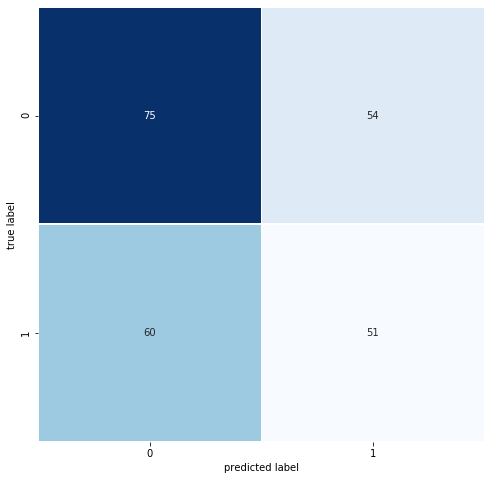

In [365]:
plot_confusion_matrix(y_test, final_ensemble_predicts)

In [358]:
final_ensemble_predicts_avg = generate_ensemble_prediction_percent(yhats, 10)

In [460]:
final_ensemble_predicts_with_hold = generate_final_prediction_counts_with_hold(ensemble_predictions, 6, 10)

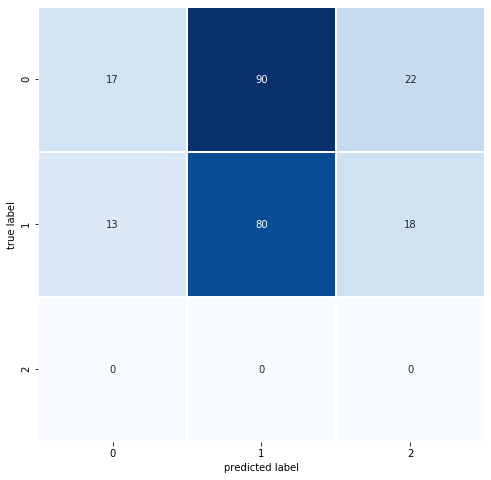

In [461]:
plot_confusion_matrix(y_test, final_ensemble_predicts_with_hold)

In [ ]:
# Now switch gears and attempt to fit a model on augmented input/training data

In [366]:
# All images will be rescaled by 1./255
# Scaled down image size from the original 255x255 as I was receiving OOM errors, otherwise
train_validate_datagen_v2 = ImageDataGenerator(rescale=1./255,
                                               shear_range=0.2,
                                               zoom_range=0.2,
                                               horizontal_flip=True,
                                               vertical_flip=True,
                                               validation_split=0.15)  # set validation split
test_datagen_v2 = ImageDataGenerator(rescale=1./255)

train_generator_v2 = train_validate_datagen_v2.flow_from_dataframe(
    dataframe=df_train,
    directory=TRAIN_PATH,
    target_size=(40, 40),
    x_col='Images',
    y_col='Labels',
    batch_size=16,
    class_mode='binary',
    subset='training')

validation_generator_v2 = train_validate_datagen_v2.flow_from_dataframe(
    dataframe=df_train,
    directory=TRAIN_PATH,
    target_size=(40, 40),
    x_col='Images',
    y_col='Labels',
    batch_size=16,
    class_mode='binary',
    subset='validation')

test_generator_v2 = test_datagen_v2.flow_from_dataframe(
    dataframe=df_test,
    x_col='Images',
    y_col='Labels',
    directory=TRAIN_PATH,
    target_size=(40, 40),
    class_mode='binary')

Found 1932 validated image filenames belonging to 2 classes.
Found 340 validated image filenames belonging to 2 classes.
Found 240 validated image filenames belonging to 2 classes.


In [369]:
model_CNN_5 = tf.keras.models.Sequential([
            #  First Convolution
            Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(40, 40, 3), kernel_initializer='he_uniform'),
            MaxPool2D((2, 2),strides=1),
            Dropout(0.25),
            # Second Convolution
            Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform'),
            Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform'),
            MaxPool2D((2, 2),strides=1),
            Dropout(0.25),
            # Third Convolution
            Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform'),
            Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform'),
            MaxPool2D((2, 2),strides=1),
            Flatten(),
            Dense(units=1024, activation='relu', kernel_initializer='he_uniform'),
            # Output layer
            Dense(1, activation='sigmoid')])

# Compiling the model
model_CNN_5.compile(
    optimizer=tf.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
    )

history_CNN_5 = model_CNN_5.fit(train_generator_v2,
                                         epochs=20,
                                         batch_size=16,
                                         validation_data=validation_generator_v2,
                                         callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
                                                   reduce_lr],
                                class_weight=weights
                                     )

Epoch 1/20
121/121 [==============================] - 9s 73ms/step - loss: 2.5007 - accuracy: 0.4943 - val_loss: 0.6974 - val_accuracy: 0.4882
Epoch 2/20
121/121 [==============================] - 9s 75ms/step - loss: 0.7363 - accuracy: 0.5160 - val_loss: 0.6941 - val_accuracy: 0.4853
Epoch 3/20
121/121 [==============================] - 9s 75ms/step - loss: 0.6990 - accuracy: 0.5155 - val_loss: 0.6922 - val_accuracy: 0.5412
Epoch 4/20
121/121 [==============================] - 9s 74ms/step - loss: 0.6976 - accuracy: 0.5041 - val_loss: 0.6936 - val_accuracy: 0.4941
Epoch 5/20
121/121 [==============================] - 9s 75ms/step - loss: 0.6928 - accuracy: 0.5052 - val_loss: 0.6938 - val_accuracy: 0.4735
Epoch 6/20
121/121 [==============================] - 9s 75ms/step - loss: 0.6901 - accuracy: 0.5331 - val_loss: 0.6938 - val_accuracy: 0.4882
Epoch 7/20
121/121 [==============================] - 9s 75ms/step - loss: 0.6942 - accuracy: 0.4979 - val_loss: 0.6928 - val_accuracy: 0.5235

In [370]:
# Now evaluate the model just trained
loss_CNN_5, accuracy_CNN_5 = model_CNN_5.evaluate(X_test, y_test)
print('test set accuracy: ', accuracy_CNN_5* 100)

8/8 [==============================] - 0s 4ms/step - loss: 0.6914 - accuracy: 0.5250
test set accuracy:  52.49999761581421


<ipython-input-371-724d83180af0>:10: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


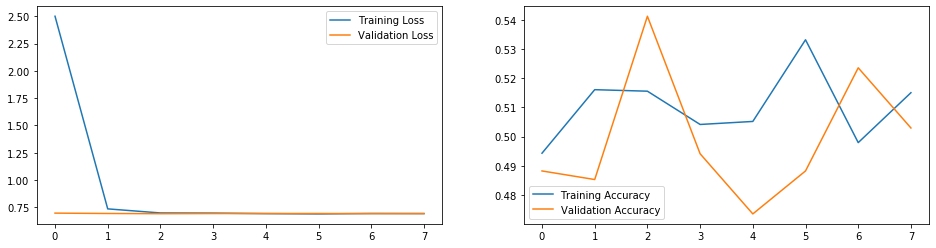

In [371]:
# Generate a plot of the training and validation losses and accuracies for the current model

plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([history_CNN_5.history['loss'], history_CNN_5.history['accuracy']], 
                                [history_CNN_5.history['val_loss'], history_CNN_5.history['val_accuracy']], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(len(history_CNN_5.history['loss'])), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(len(history_CNN_5.history['loss'])), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

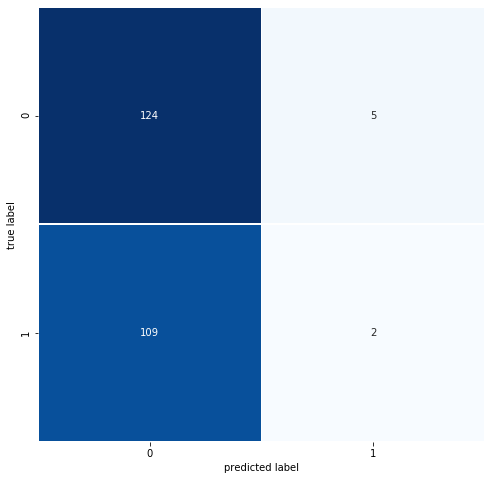

In [372]:
CNN_5_test_predict = np.asarray((model_CNN_5.predict(X_test)), dtype='float32')

predict_list = []
for i in range(0, len(CNN_5_test_predict)):
    if (CNN_5_test_predict[i] >=0.50) == True:
        current_predict = 1
        predict_list.append(current_predict)
    else:
        current_predict = 0
        predict_list.append(current_predict)
        
# Produce a confusion matrix displaying the results of predicted and true classes
plot_confusion_matrix(y_test, np.array(predict_list))